In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("/kaggle/input/formedds/formed_dataset.csv")

print("Dataset Shape:", data.shape)
print("\nColumns:\n", data.columns)
print("\nData Types:\n", data.dtypes)
print("\nMissing Values:\n", data.isnull().sum())
print("\nSample Data:\n", data.head())

# Language distribution visualization using a pie chart
if "Language" in data.columns:
    print("\nLanguage Distribution:")
    print(data["Language"].value_counts())
    
    plt.figure(figsize=(10, 8))
    data["Language"].value_counts().plot(kind="pie", autopct="%1.1f%%", startangle=140, cmap="viridis")
    plt.title("Language Distribution (Pie Chart)")
    plt.ylabel("")  # Hide y-axis label for aesthetics
    plt.show()

# Analyze text lengths
if "Text" in data.columns:
    data["text_length"] = data["Text"].str.len()
    print("\nText Length Statistics:")
    print(data["text_length"].describe())

    # Text length visualization using a box plot
    if "Language" in data.columns:
        plt.figure(figsize=(14, 8))
        sns.boxplot(data=data, x="Language", y="text_length", palette="Set2")
        plt.xticks(rotation=45)
        plt.title("Text Length Distribution by Language (Box Plot)")
        plt.xlabel("Language")
        plt.ylabel("Text Length")
        plt.show()

from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def extract_unique_words(text):
    words = text.lower().split()
    return [word for word in words if word.isalpha() and word not in stop_words]

if "Text" in data.columns:
    data["unique_words"] = data["Text"].apply(lambda x: len(set(extract_unique_words(x))))
    print("\nUnique Words Statistics:")
    print(data["unique_words"].describe())

    # Unique word per language visualization using a line plot
    if "Language" in data.columns:
        avg_unique_words = data.groupby("Language")["unique_words"].mean().sort_values()
        avg_unique_words.plot(kind="line", marker="o", figsize=(12, 8), color="coral")
        plt.title("Average Unique Words per Language (Line Plot)")
        plt.xlabel("Language")
        plt.ylabel("Average Unique Words")
        plt.grid(True)
        plt.show()


In [17]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Encode the target labels
label_encoder = LabelEncoder()
data["Language_encoded"] = label_encoder.fit_transform(data["Language"])

# Tokenize and pad the input text
max_words = 10000  # Maximum number of unique words to consider
max_len = 100  # Maximum sequence length
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(data["Text"])
sequences = tokenizer.texts_to_sequences(data["Text"])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

# One-hot encode the target labels
onehot_encoder = OneHotEncoder(sparse=False)
encoded_labels = onehot_encoder.fit_transform(data["Language_encoded"].values.reshape(-1, 1))

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dense(len(label_encoder.classes_), activation="softmax")
])

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Save the model and tokenizer
model.save("lstm_language_model.h5")
with open("tokenizer.json", "w") as f:
    f.write(tokenizer.to_json())

print("Model and tokenizer saved.")


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.0779 - loss: 3.2428 - val_accuracy: 0.0869 - val_loss: 3.2380
Epoch 2/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.0905 - loss: 3.2164 - val_accuracy: 0.1922 - val_loss: 2.5075
Epoch 3/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3100 - loss: 2.1816 - val_accuracy: 0.6814 - val_loss: 1.0008
Epoch 4/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7130 - loss: 0.9473 - val_accuracy: 0.7981 - val_loss: 0.6651
Epoch 5/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8298 - loss: 0.5714 - val_accuracy: 0.8687 - val_loss: 0.4663
Epoch 6/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8828 - loss: 0.4093 - val_accuracy: 0.8973 - val_loss: 0.3841
Epoch 7/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9061 - loss: 0.3224 - val_accuracy: 0.9040 - val_loss: 0.3442
Epoch 8/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9160 - loss: 0.2774 - val_acc

In [18]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

# Encode the target labels
label_encoder = LabelEncoder()
data["Language_encoded"] = label_encoder.fit_transform(data["Language"])

# Tokenize and pad the input text
max_words = 10000  # Maximum number of unique words to consider
max_len = 100  # Maximum sequence length
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(data["Text"])
sequences = tokenizer.texts_to_sequences(data["Text"])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

# One-hot encode the target labels
onehot_encoder = OneHotEncoder(sparse=False)
encoded_labels = onehot_encoder.fit_transform(data["Language_encoded"].values.reshape(-1, 1))

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

# Build the BiLSTM model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dense(len(label_encoder.classes_), activation="softmax")
])

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Save the model and tokenizer
model.save("bilstm_language_model.h5")
with open("tokenizer.json", "w") as f:
    f.write(tokenizer.to_json())

print("BiLSTM Model and tokenizer saved.")


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


809/809 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.3088 - loss: 2.2717 - val_accuracy: 0.8197 - val_loss: 0.6063
Epoch 2/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.8366 - loss: 0.5697 - val_accuracy: 0.8876 - val_loss: 0.3805
Epoch 3/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.8994 - loss: 0.3469 - val_accuracy: 0.9145 - val_loss: 0.2984
Epoch 4/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9194 - loss: 0.2620 - val_accuracy: 0.9054 - val_loss: 0.3109
Epoch 5/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9227 - loss: 0.2509 - val_accuracy: 0.9159 - val_loss: 0.3134
Epoch 6/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9296 - loss: 0.2214 - val_accuracy: 0.9170 - val_loss: 0.2877
Epoch 7/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9334 - loss: 0.2031 - val_accuracy: 0.9233 - val_loss: 0.2721
Epoch 8/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9349 - loss: 0.2021 - val_accurac

In [19]:
import json

# Create a mapping dictionary
unique_languages = data["Language"].unique()
language_to_index = {lang: idx for idx, lang in enumerate(unique_languages)}
index_to_language = {idx: lang for lang, idx in language_to_index.items()}

# Save the mapping as a JSON file
with open("language_mapping.json", "w") as f:
    json.dump({"language_to_index": language_to_index, "index_to_language": index_to_language}, f)


In [21]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import json

# Load the LSTM model and tokenizer
lstm_model = load_model("lstm_language_model.h5")

# Corrected tokenizer loading
with open("tokenizer.json", "r") as f:
    tokenizer = tokenizer_from_json(f.read())

# Load the BiLSTM model
bilstm_model = load_model("bilstm_language_model.h5")

# Load the language mapping
with open("language_mapping.json", "r") as f:
    mapping = json.load(f)
language_to_index = mapping["language_to_index"]
index_to_language = {int(k): v for k, v in mapping["index_to_language"].items()}  # Ensure keys are int

# Define a function to preprocess text for prediction
def preprocess_text(text, max_len=100):
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")
    return padded_sequence

# Define a function to predict the language using a given model
def predict_language(model, text):
    processed_text = preprocess_text(text)
    prediction = model.predict(processed_text)
    predicted_label_index = np.argmax(prediction, axis=1)[0]
    predicted_label = index_to_language[predicted_label_index]
    return predicted_label

# Define the actual languages for the test samples
actual_languages = [
    "Arabic", "Chinese", "Danish", "Dutch", "English", "Estonian", "French",
    "German", "Greek", "Hindi", "Indonesian", "Italian", "Japanese", "Kannada",
    "Korean", "Latin", "Malayalam", "Persian", "Portuguese", "Pushto", 
    "Romanian", "Russian", "Spanish", "Swedish", "Sweedish", "Tamil", "Thai",
    "Turkish", "Urdu"
]

# Test samples for each language
test_samples = [
    "مرحباً كيف حالك؟",  # Arabic
    "你好，你好吗？",  # Chinese
    "Hej, hvordan har du det?",  # Danish
    "Hallo, hoe gaat het?",  # Dutch
    "Hello, how are you?",  # English
    "Tere, kuidas sul läheb?",  # Estonian
    "Bonjour, comment ça va?",  # French
    "Hallo, wie geht's?",  # German
    "Γειά σας, πώς είστε;",  # Greek
    "नमस्ते, आप कैसे हैं?",  # Hindi
    "Halo, apa kabar?",  # Indonesian
    "Ciao, come stai?",  # Italian
    "こんにちは、お元気ですか？",  # Japanese
    "ಹಲೋ, ನೀವು ಹೇಗಿದ್ದೀರಾ?",  # Kannada
    "안녕하세요, 어떻게 지내세요?",  # Korean
    "Salve, quid agitur?",  # Latin
    "ഹലോ, നിങ്ങൾ എങ്ങനെ ഇരിക്കുന്നു?",  # Malayalam
    "سلام، حال شما چطور است؟",  # Persian
    "Olá, como você está?",  # Portuguese
    "سلام، حالتان چطور است؟",  # Pushto
    "Bună ziua, ce mai faceți?",  # Romanian
    "Привет, как дела?",  # Russian
    "Hola, ¿cómo estás?",  # Spanish
    "Hej, hur mår du?",  # Swedish
    "Hej, hur mår du?",  # Sweedish (same as Swedish)
    "வணக்கம், நீங்கள் எப்படி இருக்கின்றீர்கள்?",  # Tamil
    "สวัสดีครับ/ค่ะ, สบายดีไหม?",  # Thai
    "Merhaba, nasılsınız?",  # Turkish
    "ہیلو، آپ کیسے ہیں؟",  # Urdu
]

print("Predictions using LSTM:")
for i, text in enumerate(test_samples):
    predicted_language = predict_language(lstm_model, text)
    print(f"Text: {text} -> Actual Language: {actual_languages[i]} | Predicted Language: {predicted_language}")

print("\nPredictions using BiLSTM:")
for i, text in enumerate(test_samples):
    predicted_language = predict_language(bilstm_model, text)
    print(f"Text: {text} -> Actual Language: {actual_languages[i]} | Predicted Language: {predicted_language}")


Predictions using LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Text: مرحباً كيف حالك؟ -> Actual Language: Arabic | Predicted Language: Arabic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Text: 你好，你好吗？ -> Actual Language: Chinese | Predicted Language: Japanese
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Text: Hej, hvordan har du det? -> Actual Language: Danish | Predicted Language: Italian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Text: Hallo, hoe gaat het? -> Actual Language: Dutch | Predicted Language: Dutch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Text: Hello, how are you? -> Actual Language: English | Predicted Language: English
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Text: Tere, kuidas sul läheb? -> Actual Language: Estonian | Predicted Language: Japanese
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Text: Bonjour, comment ça va? -> Actual Language: French | Predicted Language: French
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Text: Hallo, wie geht's? -> Actual Language: German | Predicted Language: Malayalam
1/1 ━━

In [20]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout


label_encoder = LabelEncoder()
data["Language_encoded"] = label_encoder.fit_transform(data["Language"])

# Tokenize and pad the input text
max_words = 10000  # Maximum number of unique words to consider
max_len = 100  # Maximum sequence length
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(data["Text"])
sequences = tokenizer.texts_to_sequences(data["Text"])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

# One-hot encode the target labels
onehot_encoder = OneHotEncoder(sparse=False)
encoded_labels = onehot_encoder.fit_transform(data["Language_encoded"].values.reshape(-1, 1))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

# Build the GRU model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    GRU(64, return_sequences=True),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dense(len(label_encoder.classes_), activation="softmax")
])

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Save the model and tokenizer
model.save("gru_language_model.h5")
with open("tokenizer.json", "w") as f:
    f.write(tokenizer.to_json())

print("GRU Model and tokenizer saved.")


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


809/809 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.1064 - loss: 3.0952 - val_accuracy: 0.5875 - val_loss: 1.2206
Epoch 2/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7259 - loss: 0.9339 - val_accuracy: 0.8720 - val_loss: 0.4673
Epoch 3/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8853 - loss: 0.4174 - val_accuracy: 0.8978 - val_loss: 0.3859
Epoch 4/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9183 - loss: 0.2963 - val_accuracy: 0.9103 - val_loss: 0.3261
Epoch 5/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9280 - loss: 0.2510 - val_accuracy: 0.9066 - val_loss: 0.3337
Epoch 6/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9289 - loss: 0.2212 - val_accuracy: 0.9063 - val_loss: 0.3455
Epoch 7/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9335 - loss: 0.2148 - val_accuracy: 0.9117 - val_loss: 0.3285
Epoch 8/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9363 - loss: 0.1967 - val_accuracy: 0.91

In [12]:
import json
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load the LSTM model and tokenizer
lstm_model = load_model("lstm_language_model.h5")

# Corrected tokenizer loading
with open("tokenizer.json", "r") as f:
    tokenizer = tokenizer_from_json(f.read())

# Load the BiLSTM model
bilstm_model = load_model("bilstm_language_model.h5")

# Load the GRU model
gru_model = load_model("gru_language_model.h5")  # Load GRU model

# Load the language mapping
with open("language_mapping.json", "r") as f:
    mapping = json.load(f)
language_to_index = mapping["language_to_index"]
index_to_language = {int(k): v for k, v in mapping["index_to_language"].items()}  # Ensure keys are int

# Define a function to preprocess text for prediction
def preprocess_text(text, max_len=100):
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")
    return padded_sequence

# Define a function to predict the language using a given model
def predict_language(model, text):
    processed_text = preprocess_text(text)
    prediction = model.predict(processed_text)
    predicted_label_index = np.argmax(prediction, axis=1)[0]
    predicted_label = index_to_language[predicted_label_index]
    return predicted_label

# Define the actual languages for the test samples
actual_languages = [
    "Arabic", "Chinese", "Danish", "Dutch", "English", "Estonian", "French",
    "German", "Greek", "Hindi", "Indonesian", "Italian", "Japanese", "Kannada",
    "Korean", "Latin", "Malayalam", "Persian", "Portuguese", "Pushto", 
    "Romanian", "Russian", "Spanish", "Swedish", "Sweedish", "Tamil", "Thai",
    "Turkish", "Urdu"
]

# Test samples for each language
test_samples = [
    "مرحباً كيف حالك؟",  # Arabic
    "你好，你好吗？",  # Chinese
    "Hej, hvordan har du det?",  # Danish
    "Hallo, hoe gaat het?",  # Dutch
    "Hello, how are you?",  # English
    "Tere, kuidas sul läheb?",  # Estonian
    "Bonjour, comment ça va?",  # French
    "Hallo, wie geht's?",  # German
    "Γειά σας, πώς είστε;",  # Greek
    "नमस्ते, आप कैसे हैं?",  # Hindi
    "Halo, apa kabar?",  # Indonesian
    "Ciao, come stai?",  # Italian
    "こんにちは、お元気ですか？",  # Japanese
    "ಹಲೋ, ನೀವು ಹೇಗಿದ್ದೀರಾ?",  # Kannada
    "안녕하세요, 어떻게 지내세요?",  # Korean
    "Salve, quid agitur?",  # Latin
    "ഹലോ, നിങ്ങൾ എങ്ങനെ ഇരിക്കുന്നു?",  # Malayalam
    "سلام، حال شما چطور است؟",  # Persian
    "Olá, como você está?",  # Portuguese
    "سلام، حالتان چطور است؟",  # Pushto
    "Bună ziua, ce mai faceți?",  # Romanian
    "Привет, как дела?",  # Russian
    "Hola, ¿cómo estás?",  # Spanish
    "Hej, hur mår du?",  # Swedish
    "Hej, hur mår du?",  # Sweedish (same as Swedish)
    "வணக்கம், நீங்கள் எப்படி இருக்கின்றீர்கள்?",  # Tamil
    "สวัสดีครับ/ค่ะ, สบายดีไหม?",  # Thai
    "Merhaba, nasılsınız?",  # Turkish
    "ہیلو، آپ کیسے ہیں؟",  # Urdu
]

print("Predictions using LSTM:")
for i, text in enumerate(test_samples):
    predicted_language = predict_language(lstm_model, text)
    print(f"Text: {text} -> Actual Language: {actual_languages[i]} | Predicted Language: {predicted_language}")

print("\nPredictions using BiLSTM:")
for i, text in enumerate(test_samples):
    predicted_language = predict_language(bilstm_model, text)
    print(f"Text: {text} -> Actual Language: {actual_languages[i]} | Predicted Language: {predicted_language}")

print("\nPredictions using GRU:")
for i, text in enumerate(test_samples):
    predicted_language = predict_language(gru_model, text)
    print(f"Text: {text} -> Actual Language: {actual_languages[i]} | Predicted Language: {predicted_language}")


Predictions using LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Text: مرحباً كيف حالك؟ -> Actual Language: Arabic | Predicted Language: Arabic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Text: 你好，你好吗？ -> Actual Language: Chinese | Predicted Language: Chinese
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Text: Hej, hvordan har du det? -> Actual Language: Danish | Predicted Language: Portugeese
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Text: Hallo, hoe gaat het? -> Actual Language: Dutch | Predicted Language: Dutch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Text: Hello, how are you? -> Actual Language: English | Predicted Language: English
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Text: Tere, kuidas sul läheb? -> Actual Language: Estonian | Predicted Language: Japanese
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Text: Bonjour, comment ça va? -> Actual Language: French | Predicted Language: French
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Text: Hallo, wie geht's? -> Actual Language: German | Predicted Language: German
1/1 ━━━

Unique languages in actual_languages: {'Hindi', 'Danish', 'German', 'Thai', 'Italian', 'Greek', 'Korean', 'French', 'Spanish', 'Persian', 'English', 'Malayalam', 'Russian', 'Portuguese', 'Kannada', 'Tamil', 'Romanian', 'Japanese', 'Dutch', 'Chinese', 'Swedish', 'Urdu', 'Latin', 'Pushto', 'Estonian', 'Turkish', 'Arabic', 'Indonesian'}
Classes in LabelEncoder: ['Arabic' 'Chinese' 'Danish' 'Dutch' 'English' 'Estonian' 'French'
 'German' 'Greek' 'Hindi' 'Indonesian' 'Italian' 'Japanese' 'Kannada'
 'Korean' 'Latin' 'Malayalam' 'Persian' 'Portuguese' 'Portugese' 'Pushto'
 'Romanian' 'Russian' 'Spanish' 'Swedish' 'Tamil' 'Thai' 'Turkish' 'Urdu']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━

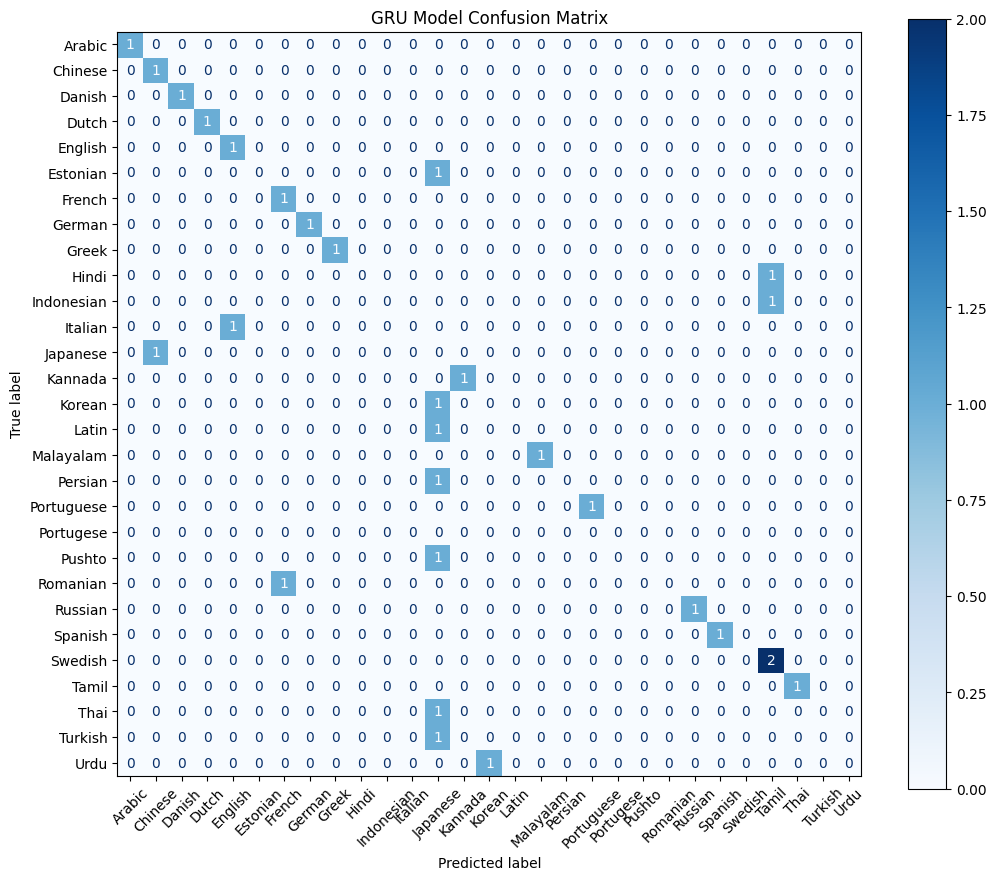

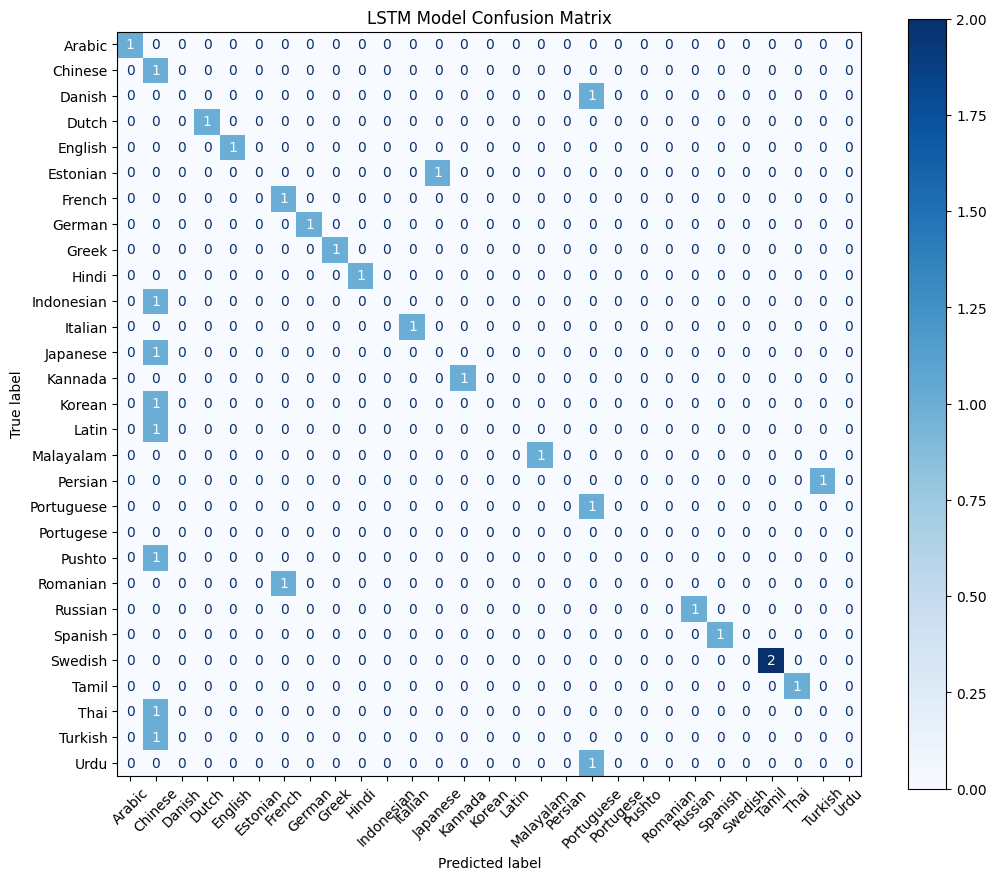

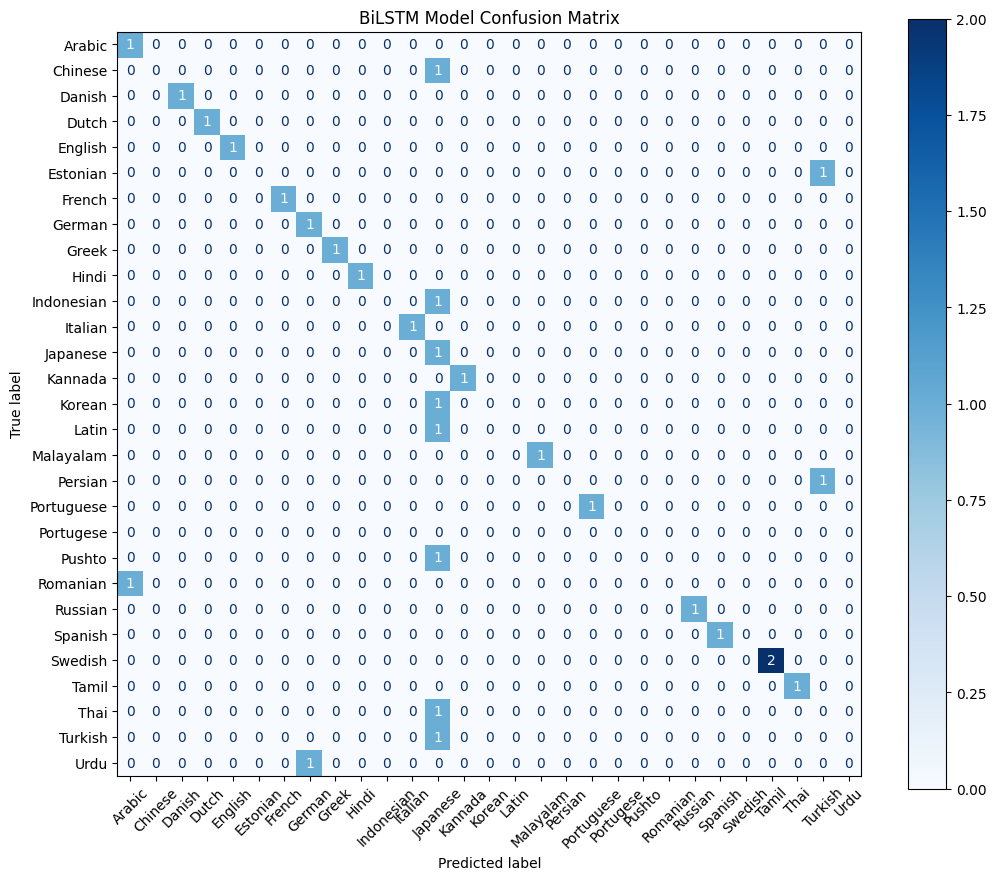

In [18]:
import numpy as np
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the GRU, LSTM, and BiLSTM models
gru_model = load_model("gru_language_model.h5")
lstm_model = load_model("lstm_language_model.h5")
bilstm_model = load_model("bilstm_language_model.h5")

# Load the tokenizer
with open("tokenizer.json", "r") as f:
    tokenizer = tokenizer_from_json(f.read())

# Load the language mapping
with open("language_mapping.json", "r") as f:
    mapping = json.load(f)
language_to_index = mapping["language_to_index"]
index_to_language = {int(k): v for k, v in mapping["index_to_language"].items()}  # Ensure keys are int

# Encode the languages
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array([index_to_language[i] for i in range(len(index_to_language))])

# Define a function to preprocess text for prediction
def preprocess_text(text, max_len=100):
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")
    return padded_sequence

# Define a function to predict the language using a given model
def predict_language(model, text):
    processed_text = preprocess_text(text)
    prediction = model.predict(processed_text)
    predicted_label_index = np.argmax(prediction, axis=1)[0]
    predicted_label = index_to_language[predicted_label_index]
    return predicted_label

# Function to plot confusion matrix
def plot_confusion_matrix(predictions, actuals, label_encoder, title):
    encoded_actuals = label_encoder.transform(actuals)
    encoded_predictions = label_encoder.transform(predictions)

    cm = confusion_matrix(encoded_actuals, encoded_predictions, labels=range(len(label_encoder.classes_)))
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

    plt.figure(figsize=(12, 10))
    display.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Test samples and their actual languages
test_samples = [
    "مرحباً كيف حالك؟", "你好，你好吗？", "Hej, hvordan har du det?", "Hallo, hoe gaat het?",
    "Hello, how are you?", "Tere, kuidas sul läheb?", "Bonjour, comment ça va?", "Hallo, wie geht's?",
    "Γειά σας, πώς είστε;", "नमस्ते, आप कैसे हैं?", "Halo, apa kabar?", "Ciao, come stai?",
    "こんにちは、お元気ですか？", "ಹಲೋ, ನೀವು ಹೇಗಿದ್ದೀರಾ?", "안녕하세요, 어떻게 지내세요?", "Salve, quid agitur?",
    "ഹലോ, നിങ്ങൾ എങ്ങനെ ഇരിക്കുന്നു?", "سلام، حال شما چطور است؟", "Olá, como você está?",
    "سلام، حالتان چطور است؟", "Bună ziua, ce mai faceți?", "Привет, как дела?", "Hola, ¿cómo estás?",
    "Hej, hur mår du?", "Hej, hur mår du?", "வணக்கம், நீங்கள் எப்படி இருக்கின்றீர்கள்?", 
    "สวัสดีครับ/ค่ะ, สบายดีไหม?", "Merhaba, nasılsınız?", "ہیلو، آپ کیسے ہیں؟"
]

# Correct the typo in actual languages
actual_languages = [
    "Arabic", "Chinese", "Danish", "Dutch", "English", "Estonian", "French", "German",
    "Greek", "Hindi", "Indonesian", "Italian", "Japanese", "Kannada", "Korean", "Latin",
    "Malayalam", "Persian", "Portuguese", "Pushto", "Romanian", "Russian", "Spanish",
    "Swedish", "Swedish", "Tamil", "Thai", "Turkish", "Urdu"
]

# Debug: Print unique labels
print(f"Unique languages in actual_languages: {set(actual_languages)}")
print(f"Classes in LabelEncoder: {label_encoder.classes_}")

# Predict languages using each model
gru_predictions = [predict_language(gru_model, text) for text in test_samples]
lstm_predictions = [predict_language(lstm_model, text) for text in test_samples]
bilstm_predictions = [predict_language(bilstm_model, text) for text in test_samples]

# Plot confusion matrices
plot_confusion_matrix(gru_predictions, actual_languages, label_encoder, "GRU Model Confusion Matrix")
plot_confusion_matrix(lstm_predictions, actual_languages, label_encoder, "LSTM Model Confusion Matrix")
plot_confusion_matrix(bilstm_predictions, actual_languages, label_encoder, "BiLSTM Model Confusion Matrix")


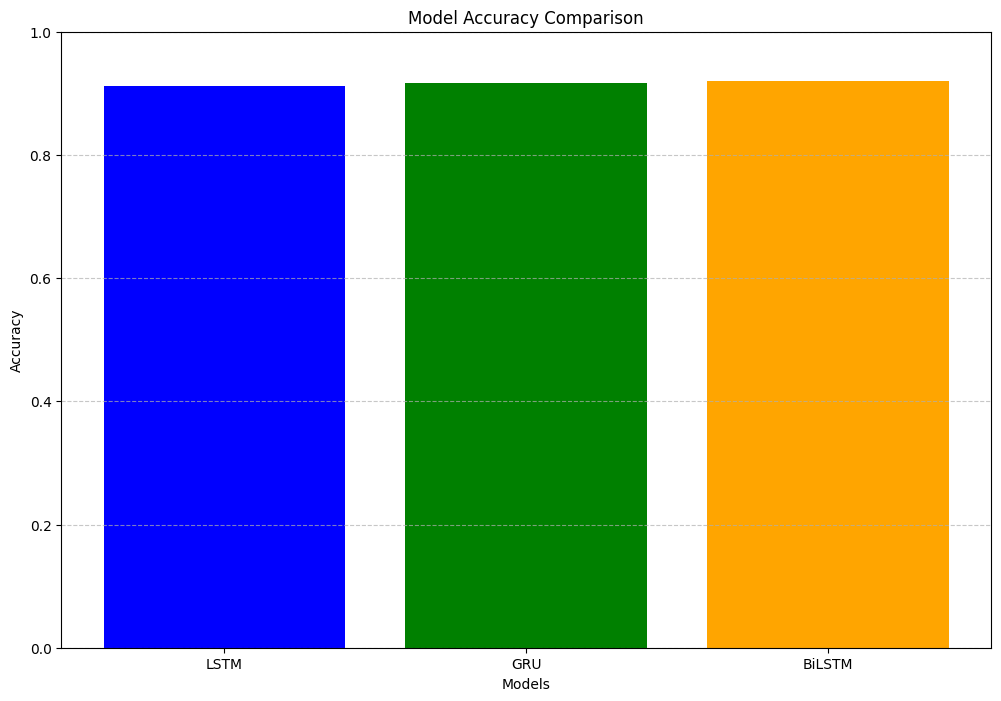

In [28]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load the models
lstm_model = load_model('/kaggle/working/lstm_language_model.h5')
gru_model = load_model('/kaggle/working/gru_language_model.h5')
bilstm_model = load_model('/kaggle/working/bilstm_language_model.h5')

# Define your test data (replace these with your actual test data)
# Assuming you have X_test (features) and y_test (labels) already available
# Example of padding and preparing the test data
maxlen = 100  # Example: Replace with the sequence length you used for training
X_test_padded = pad_sequences(X_test, padding='post', maxlen=maxlen)  # Replace `maxlen` with the actual sequence length
y_test = np.array(y_test)  # Ensure your test labels are in a numpy array

# Evaluate the models
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_padded, y_test, verbose=0)
gru_loss, gru_accuracy = gru_model.evaluate(X_test_padded, y_test, verbose=0)
bilstm_loss, bilstm_accuracy = bilstm_model.evaluate(X_test_padded, y_test, verbose=0)

# List of model accuracies and labels for plotting
accuracies = [lstm_accuracy, gru_accuracy, bilstm_accuracy]
labels = ["LSTM", "GRU", "BiLSTM"]

# Plotting the accuracies as a bar plot
plt.figure(figsize=(12, 8))
plt.bar(labels, accuracies, color=['blue', 'green', 'orange'])
plt.title("Model Accuracy Comparison")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # Set y-axis limits to [0, 1] for accuracy range
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
